# Imports

In [4]:
import joblib
import optuna
import os,sys,inspect
import numpy as np
import matplotlib.pyplot as plt
from mne.datasets.sleep_physionet.age import fetch_data
import mne
import pandas as pd
from scipy import signal
from scipy.fftpack import fft

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from src.features.build_features import break_2_bands, channels_fft, eeg_power_band

# Fetching Sleeping data from Physionet (PSG + Hyp)

In [5]:
# Fetching data
files = fetch_data(subjects=[0], recording=[1])
psg = files[0][0]
anno = files[0][1]
select_ch = ['EEG Fpz-Cz', 'EEG Pz-Oz']
# Reading PSG and Hyp files
raw = mne.io.read_raw_edf(psg, preload=True, stim_channel=None)
raw_eeg = raw.pick_channels(select_ch)
annot = mne.read_annotations(anno)

sampling_rate = raw.info['sfreq']

df = raw.to_data_frame(scalings=100.0)[select_ch]

annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# Events from annotation file
# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot.crop(annot[1]['onset'] - 30 * 60,
                 annot[-2]['onset'] + 30 * 60)
raw.set_annotations(annot, emit_warning=False)

events, _ = mne.events_from_annotations(
    raw, event_id = annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from C:\Users\orelt\mne_data\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


# Pre processing:
1. Band pass filter to bands
2. FFT

In [6]:
# Preprocessing
df1 = break_2_bands(df)

df2 = channels_fft(df)

df1.set_index(np.arange(len(df1)))
df2.set_index(np.arange(len(df2)))

,EEG Fpz-Cz_fft,EEG Pz-Oz_fft
0,131.576720,278.928752
1,1.139181,1.322771
2,0.938774,0.834076
3,0.596252,0.426689
4,0.163376,2.080166
...,...,...
7949995,1.078992,1.178490
7949996,0.163376,2.080166
7949997,0.596252,0.426689
7949998,0.938774,0.834076


# Plots

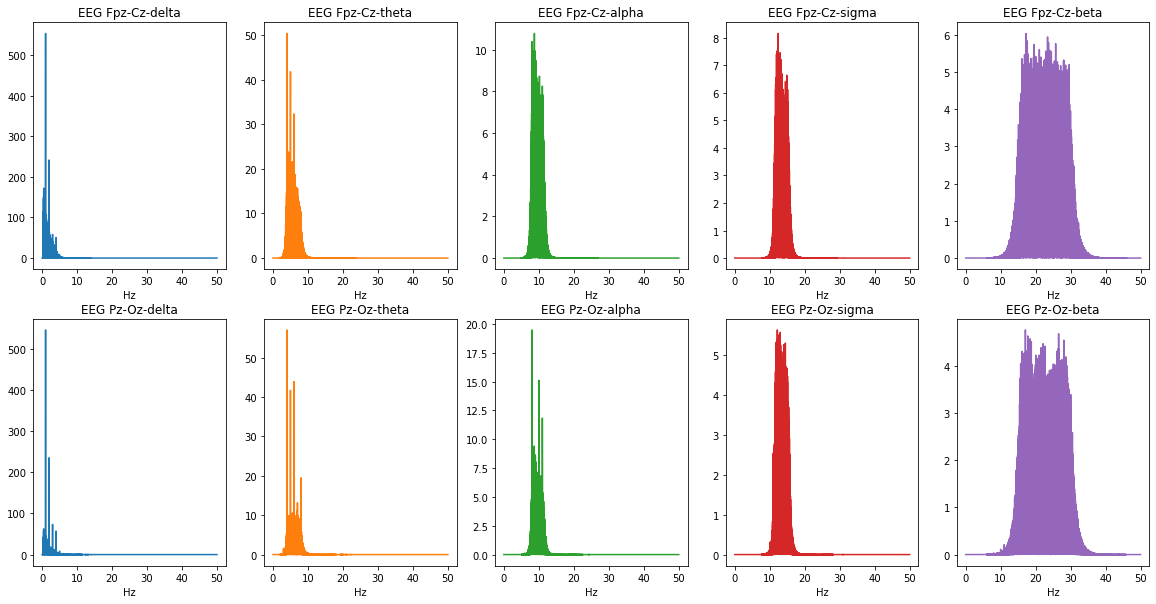

In [7]:
#########################
#   PLOT FFT of 5 bands 
#########################
Fs = sampling_rate
T = 1/Fs
N = len(df1)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

bands_str = ["delta", "theta", "alpha", "sigma", "beta"]
fig = plt.figure(figsize=(20, 10))
for band in range(len(df1.columns)):
    ax = fig.add_subplot(2, 5, band+1)
    ffted = abs(fft(df1.iloc[:, band].values))
    ax.set_title(df1.columns[band].split("_")[0] + "-" + bands_str[band % 5])
    ax.set_xlabel("Hz")
    ax.plot(xf, ffted[:N//2], 'C'+ str(band % 5))
    
plt.show()

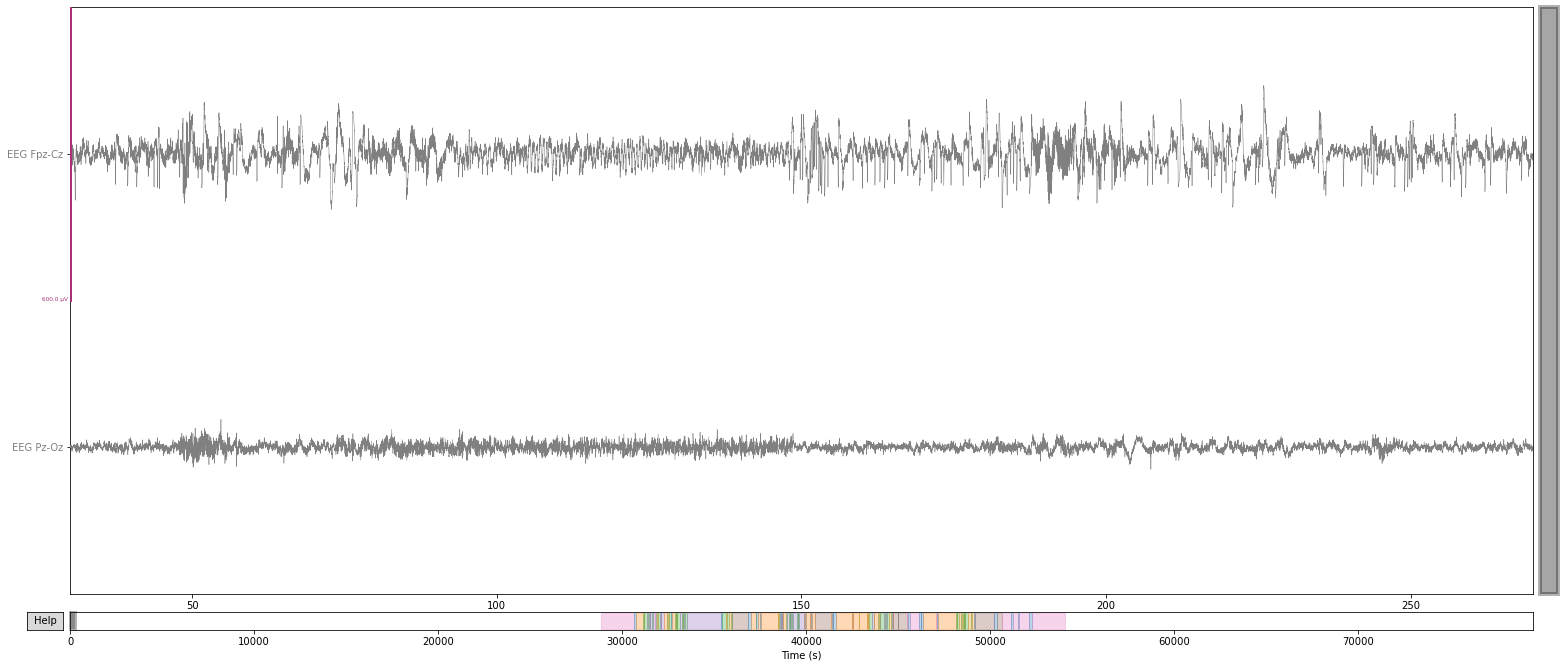

AttributeError: 'ArtistList' object has no attribute 'get_xdata'

In [32]:
#########################################
#   PLOT eeg data using mne 
#########################################

fig = mne.viz.plot_raw(raw, start=30, duration=240, event_color='r', events=events, color="gray",
         scalings=dict(eeg=3e-4))
for ax in fig.axes[1:]:
    time = ax.lines[-1].get_xdata()
    eeg = ax.lines[-1].get_ydata()
    print(eeg)
    for t in (60, 90, 120, 150):
        idx = np.searchsorted(time, t)
        ax.arrow(x=time[idx], y=eeg[idx] , color='red',
                 width=0.1, head_width=3, length_includes_head=True)


In [43]:
fig.axes[0].lines[-1].get_ydata()

array([-0.5,  0.5])

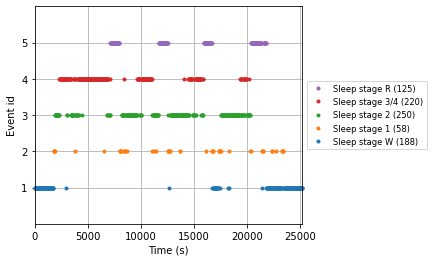

In [10]:
#########################################
#   PLOT sleeping events of MNE data 
#########################################

# plot events
fig = mne.viz.plot_events(events, event_id=event_id,
                          sfreq=raw.info['sfreq'],
                          first_samp=events[0, 0])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Not setting metadata
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Loading data for 841 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


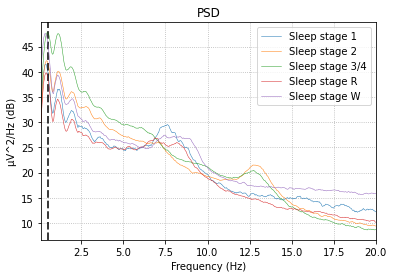

In [13]:
# Plot PSD
# Create Epochs from the data based on the events found in the annotations
tmax = 30. - 1. / sampling_rate  # tmax in included

epochs = mne.Epochs(raw=raw, events=events, preload=True,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

fig, ax = plt.subplots(ncols=1)
stages = sorted(event_id.keys())
for stage, color in zip(stages, stage_colors):
    epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,
                           fmin=0.1, fmax=20., show=False,
                           average=True, spatial_colors=False)
ax.set(title="PSD", xlabel='Frequency (Hz)')
ax.set(ylabel='µV^2/Hz (dB)')
ax.legend(ax.lines[2::3], stages)
plt.show()

In [ ]:
# X = eeg_power_band(epochs_eeg)

In [ ]:
# data = np.abs(data["x"])
# coms = []
# for yf in data:
#     Fs = 100
#     T = 1/Fs
#     N = yf.shape[0]
#     xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
#     y = yf[:, 0]

#     com = 0
#     for index, _ in enumerate(xf):
#         com += xf[index] * y[index]

#     com /= sum(y)
#     coms.append(com)
    
# fig, ax = plt.subplots()
# ax.plot(coms)
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(xf, np.abs(y[:N//2]))
# plt.show()

In [ ]:
# study = joblib.load('SC4001E0.pkl')
# df = study.trials_dataframe().drop(['state', 'datetime_start', 'datetime_complete'], axis=1)
# print(optuna.visualization.is_available())

In [ ]:
# fig = optuna.visualization.plot_optimization_history(study)
# fig.show()